<a href="https://colab.research.google.com/github/teang1995/CAM-Class-Activation-Map-/blob/main/ClassActivationMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class vgg_cam(nn.Module):
  def __init__(self, features, num_classes, init_weights=True):
    super(vgg_cam, self).__init__()
    self.features = features
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.classfier = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.features(x)
    map = x
    x = self.avgpool(x)
    x = torch.squeeze(x)
    x = self.classfier(x)
    return x, map

In [3]:
vgg16 = models.vgg16(pretrained=True)
features = vgg16.features
features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [4]:
model = vgg_cam(features=features,
                num_classes = 10,
                init_weights=True)
PATH = '/content/drive/MyDrive/vgg_cam.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [5]:
transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [6]:
train_dataset = datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(len(train_dataset), len(test_dataset))

50000 10000


In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

len_train = len(train_loader)
len_test = len(test_loader)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

vgg_cam(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10

In [11]:
# for epoch in range(epochs):
#   train_loss = 0
#   test_loss = 0
#   for data_, target_ in train_loader:
#     data = data_.to(device)
#     target = target_.to(device)
#     output_, _ = model(data)
#     output = torch.squeeze(output_)
#     optimizer.zero_grad()
#     loss = criterion(output, target) 
#     train_loss += loss.item()
#     loss.backward()
#     optimizer.step()
#   print("{}epoch train loss : {}".format(epoch + 1, round(train_loss / len_train, 2)))

#   for data_, target_ in test_loader:
#     data = data_.to(device)
#     target = target_.to(device)
#     output_, _ = model(data)
#     loss = criterion(output, target)
#     test_loss += loss.item()
#   print("{}epoch test loss : {}".format(epoch + 1, round(test_loss / len_test, 2)))



In [12]:
img = test_dataset[0][0]
label = test_dataset[0][1]
batch_img = img[None, :, :, :].to(device)
x, map = model(batch_img)

In [13]:
class_weight = model.classfier.weight[3].unsqueeze(-1).unsqueeze(-1)
cam_ = torch.squeeze(map) * class_weight
cam = torch.sum(cam_, axis=0)
cam = cam.detach().cpu().numpy()
# print(cam.shape) DEBUG

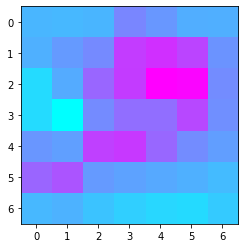

In [14]:
plt.imshow(cam, cmap='cool', interpolation='nearest')
plt.show()

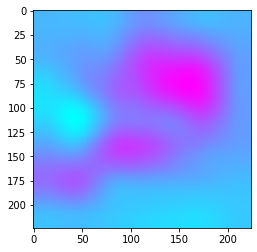

In [15]:
import cv2
final_cam = cv2.resize(cam, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(final_cam, cmap='cool', interpolation='nearest')
plt.show()

In [16]:
origin = img.detach().numpy()
origin.shape

(3, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


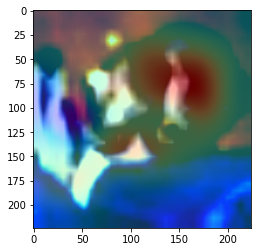

In [17]:
plt.imshow(np.rollaxis(origin, 0, 3))
plt.imshow(final_cam, alpha=0.4, cmap='rainbow')
plt.show()